##  1- Instalação/Configuração/Import

In [ ]:
!pip install transformers
!pip install ipymarkup

     |████████████████████████████████| 2.9 MB 2.7 MB/s 
     |████████████████████████████████| 895 kB 48.6 MB/s 
     |████████████████████████████████| 56 kB 5.8 MB/s 
     |████████████████████████████████| 3.3 MB 57.9 MB/s 
     |████████████████████████████████| 636 kB 76.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26119 sha256=79d7e7fee3318a4924d5cf043d5fa3a8011807c86359cf8d3c59af5df8f49ae9
  Stored in directory: /root/.cache/pip/wheels/16/85/bd/1001cbb46dcfb71c2001cd7401c6fb250392f22a81ce3722f7
Successfully built intervaltree
  Attempting uninstall: intervaltree
    Found existing installation: intervaltree 2.1.0
    Uninstalling intervaltree-2.1.0:
      Successfully uninstalled intervaltree-2.1.0


In [ ]:
from typing import Dict, List, Tuple, Union
import re
import json
from dataclasses import dataclass
import itertools

import pandas as pd

import os
import gc
from tqdm import tqdm

from transformers import AutoModel, AutoTokenizer
from transformers import BertTokenizerFast, DistilBertTokenizerFast, BatchEncoding, PreTrainedTokenizerFast, TrainingArguments, Trainer
from transformers import BertForTokenClassification, DistilBertForTokenClassification
from tokenizers import Encoding

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from ipymarkup import show_box_markup
from ipymarkup import show_line_markup
from ipymarkup.palette import palette, BLUE, RED, GREEN, BROWN, GREY, ORANGE

import torch
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import numpy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2 - Funções Gerais

In [ ]:
# Liberar e monitorar memória da GPU
def destroy_model(model: Union[DistilBertForTokenClassification,BertForTokenClassification]):
    del model
    gc.collect()
    torch.cuda.empty_cache()

def destroy_tokenizer(tokenizer: Union[BertTokenizerFast, DistilBertTokenizerFast]):
    del tokenizer
    gc.collect()
    torch.cuda.empty_cache()

def get_gpu_memory_status():
    total = (torch.cuda.get_device_properties(0).total_memory)/(1024 **2)
    reserved = (torch.cuda.memory_reserved(0))/(1024 **2)
    allocated = (torch.cuda.memory_allocated(0))/(1024 **2)
    return f"Total: {total:.2f} | Reserved: {reserved:.2f} | Allocated: {allocated:.2f}"


In [ ]:
def plot_grafico_trainer_loss(trainer_loss: numpy.ndarray, validation_loss: numpy.ndarray):
    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)

    # Plot the learning curve.
    plt.plot(trainer_loss[:,0],trainer_loss[:,1] , label="training loss")
    plt.plot(validation_loss[:,0], validation_loss[:,1] , label="validation loss")

    # Label the plot.
    plt.title("Learning curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

## 3 - Constantes

In [ ]:
GDRIVE_PATH:str = '/content/drive/MyDrive'
DATASET_PRIMEIRO_HAREM = os.path.join(GDRIVE_PATH, 'dataset', 'po-ner', '02-portuguese-ner', 'CDPrimeiroHAREMprimeiroevento.json')
DATASET_MINI_HAREM = os.path.join(GDRIVE_PATH, 'dataset', 'po-ner', '02-portuguese-ner', 'CDPrimeiroHAREMMiniHAREM.json')    
DATASET_SEGUNDO_HAREM = os.path.join(GDRIVE_PATH, 'dataset', 'po-ner', '02-portuguese-ner', 'CDSegundoHAREMReRelEM.json')    
DATASETS_HAREM=[DATASET_PRIMEIRO_HAREM, DATASET_MINI_HAREM, DATASET_SEGUNDO_HAREM]

LABEL_LIST = [
    'PESSOA',
    'ORGANIZACAO',
    'LOCAL',
    'TEMPO',
    'VALOR',
]

SEPARADOR_SENTENCA = ['.', '?', '!']
PUNCTUATION_LIST = [ ',','.',':',';']
CONTROL_TOKENS = ['[PAD]', '[SEP]', '[CLS]' ]

MODEL_BASE: str = 'neuralmind/bert-base-portuguese-cased'
MODEL_TRAINED_PATH: str = os.path.join(GDRIVE_PATH, 'model', 'PO-NER', 'portuguese-ner')
MODEL_TRAINED_LOG: str = os.path.join(MODEL_TRAINED_PATH, 'trainer.log')
LABEL_OUTPUT_PATH: str = os.path.join(MODEL_TRAINED_PATH, 'labelset.txt')

## 4 - Classes 

In [ ]:
#------------------------------------------------------------------------------#
class Anotacao:
    """
        Representa uma anotação de entidade, contendo o texto, label e span(inicio, fim).
    """ 
    def __init__(self):
        self.text: str = ''
        self.label: str = ''
        self.start_offset: int = 0
        self.end_offset: int = 0

    def __str__(self):
        return f"{self.text} - ({self.label}) - {self.start_offset}:{self.end_offset} \n"

    def __repr__(self):
        return self.__str__()

    def copy_from(self, origem) -> None:
        """ 
            Args:
                origem(Anotacao):
                    copia os dados da anotação origem
            Returns:
                None
        """
        self.text = origem.text
        self.label = origem.label
        self.start_offset = origem.start_offset
        self.end_offset = origem.end_offset

#------------------------------------------------------------------------------#
class Document:
    """
        Representa um documento e suas entidades associadas, identificadas por Anotações.
        Contém também uma representação estatística para montagem dos Data Frames
    """

    def __init__(self):
        self.text: str = None
        self.lista_anotacao: List[Anotacao] = []
        self.numero_palavras: int = 0
        self.numero_ent_label: Dict[str, int] = {}
        
        for label in LABEL_LIST:
            self.numero_ent_label[label] = 0
    
    def __str__(self):
            return f"{self.text[0:30]}... Anotacoes({len(self.lista_anotacao)}) Palavras({self.numero_palavras}) Quantidades({self.numero_ent_label})"

    def __repr__(self):
        return self.__str__()
    
    def adiciona_anotacao(self, anotacao: Anotacao) -> None:
        self.lista_anotacao.append(anotacao)
        self.__incrementa_label(anotacao.label)

    def __incrementa_label(self, label) -> None:
        self.numero_ent_label[label] += 1
    
    def conta_palavras(self) -> None:
        self.numero_palavras = len(self.text.split())
    
    def to_dict(self) -> Dict[str,int]: 
        return {
            'text': self.text,
            'numero_palavras': self.numero_palavras,
            'QTD_PESSOA' : self.numero_ent_label['PESSOA'],
            'QTD_ORGANIZACAO': self.numero_ent_label['ORGANIZACAO'],
            'QTD_LOCAL' : self.numero_ent_label['LOCAL'],
            'QTD_TEMPO' : self.numero_ent_label['TEMPO'],
            'QTD_VALOR' : self.numero_ent_label['VALOR']
        }

In [ ]:
@dataclass
class TrainingBatchExample:
    batch_encoding: BatchEncoding
    labels: List[List[int]]

In [ ]:
class NERDataset(torch.utils.data.Dataset):
    """
        Subclasse do Dataset Torch utilizada para abstrair a complexidade dos itens informados ao modelo
        durante o treino, validação e teste.
    """
    def __init__(self, batch: Union[BatchEncoding, TrainingBatchExample], labels: List[List[int]]=None):
        _batch_encodings: BatchEncoding = None
        _labels: List[List[int]] = []

        if isinstance(batch, TrainingBatchExample):
            _batch_encodings = batch.batch_encoding
            _labels = batch.labels
        else:
            _batch_encodings = batch
            _labels = labels

        if ("offset_mapping" in _batch_encodings):
            _batch_encoding.pop("offset_mapping")
        self.batch_encodings = _batch_encodings
        self.labels = _labels        

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.batch_encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        if self.labels is not None:
            return len(self.labels)
        else:
            return len(self.batch_encodings.encodings)

In [ ]:
class LabelNER:
    """
        Classe preparada que contém os labels de um treinamento e teste supervisionado de NER.
        Essa versão do LabelNer trata somente labels com span's, ou seja, a lista de inicialização não contém prefixos e o O(utside) 

        load_from_list e load_from_annotations devem ser utilizados no treinamento.
        Ao terminar o treinamento salvar um cópia com o método save().
        No caso de predição ou carga para teste utilizar o load_from_file() para carregar um label set com a mesma ordem utilizada no treino.
     
    """

    def __str__(self):
            return f"{len(self.labels_to_id)} labels {str(self.labels_to_id)}"

    def __repr__(self):
        return self.__str__()

    def __len__(self):
        return len(self.labels_to_id)

    def __init__(self):
        self.labels_to_id = {}
        self.ids_to_label = {}
        
    def get_label_list(self):
        return self.labels_to_id.keys()

    def get_id_list(self):
        return self.ids_to_label.keys()

    def load_from_simple_list(self, labels: List[str]) -> None:
        '''
            Args: 
                labels(:obj:`List[str]`):
                    Lista de labels sem prefixo e não contendo o tipo O(utside).
            
            Inclui o tipo O(utside) e faz a permutação entre labels e os prefixos do formato informado
        '''
        self.labels_to_id["O"] = 0
        self.ids_to_label[0] = "O"
        num = 0  # in case there are no labels
        prefix_list: str = "BI" 
        for _num, (label, s) in enumerate(itertools.product(labels, prefix_list)):
            num = _num + 1  # skip 0
            l = f"{s}-{label}"
            self.labels_to_id[l] = num
            self.ids_to_label[num] = l
        
     
    def load_from_file(self, input_file_path:str) -> None:
        '''
            Carrega o arquivo com os labels ordenados. O arquivo pode ser construido manualmente, mas deve conter um label por linha, na ordem utilizada para treinar o modelo, já que essa ordem foi criada na 
            extração ou carga dos labels para o treinamento do modelo.

            Args: 
                labelset_file(:obj:`str`):
                    Nome do arquivo contendo a lista de labels previamente gravado. Muito importante ter sido gravado por essa classe ou ter a garantia que o arquivo está com os labels na ordem correta.           
        '''
        with open(input_file_path, 'r' ) as label_file:
            for ind, label in enumerate(label_file):
                label = label.strip('\n')
                self.labels_to_id[label] = ind
                self.ids_to_label[ind] = label

    def save(self, output_file_path: str):
        with open(output_file_path, 'w' ) as label_file:
            for label in self.labels_to_id:
                label_file.write(label)
                label_file.write('\n')    


    def convert_label_list_to_id_list(self, lista: List[str]) -> List[int]:
        """
            Converte uma lista de labels nos respectivos id`s. Para processamento no modelo essa conversão precisará ser realizada
        """
        return list(map(self.labels_to_id.get, lista))

    def convert_id_list_to_label_list(self, lista: List[int]) -> List[str]:
        """
            Converte uma lista de id`s nos respectivos labels. Para compreensão do resultado retornado pelo modelo essa conversão será necessária.
        """
        return list(map(self.ids_to_label.get, lista))  


## 5 - Carga dos Datasets

In [ ]:
def carrega_dataset_harem(file_name:str) -> List[Document]:
    """
        Carrega o dataset Harem no formato JSON.
        O formato origem do Harem é XML, mas convertemos para JSON em etapa anterior.
        Formato esperado:
        [
            {
                doc_id: str
                doc_text: str
                entities: [{
                    entity_id: str
                    text: str
                    start_offset: int
                    end_offset: int
                }]
            }
        ]
        
        Args:
            file_name(str):
                nome do arquivo que será carregado

        Returns:
            List[Document]:
                retorna a lista de documentos e suas anotações

    """ 

    doc_list: List[Document] =[]

    with open(file_name) as json_ds_file:
        raw = json.load(json_ds_file)
        for example in raw:
            doc = Document()
            doc.text = example['doc_text']
            
            for an_ent in example['entities']:
                anotacao = Anotacao()
                anotacao.text = an_ent['text']
                anotacao.label = an_ent['label']
                anotacao.start_offset = an_ent['start_offset']
                anotacao.end_offset = an_ent['end_offset']
                
                doc.adiciona_anotacao(anotacao)
            doc.conta_palavras()

            doc_list.append(doc)
    return doc_list

In [ ]:
# carrega separadamente cada um dos datasets
prim_harem_lista_doc = carrega_dataset_harem(DATASET_PRIMEIRO_HAREM)
mini_harem_lista_doc = carrega_dataset_harem(DATASET_MINI_HAREM)
segundo_harem_lista_doc = carrega_dataset_harem(DATASET_SEGUNDO_HAREM)

# gera um dataset harem único, contendo textos dos 3 datasets
lista_doc_harem: List[Document] = []
lista_doc_harem.extend(prim_harem_lista_doc)
lista_doc_harem.extend(mini_harem_lista_doc)
lista_doc_harem.extend(segundo_harem_lista_doc)


## 6 - Analise dos Datasets

In [ ]:
df = pd.DataFrame([o.to_dict() for o in lista_doc_harem])

In [ ]:
df.describe()

,numero_palavras,QTD_PESSOA,QTD_ORGANIZACAO,QTD_LOCAL,QTD_TEMPO,QTD_VALOR
count,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000
mean,527.976684,10.295337,6.606218,9.176166,5.147668,2.919689
std,647.514683,16.296628,9.981820,11.533128,6.540698,4.828624
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,225.250000,1.000000,1.000000,2.000000,1.000000,0.000000
50%,318.000000,5.000000,3.000000,5.000000,3.000000,1.000000
75%,609.750000,13.000000,9.000000,12.000000,7.000000,4.000000
max,7246.000000,174.000000,89.000000,72.000000,46.000000,43.000000


In [ ]:
df.head(15)

,text,numero_palavras,QTD_PESSOA,QTD_ORGANIZACAO,QTD_LOCAL,QTD_TEMPO,QTD_VALOR
0,Abraço Página Principal ASSOCIAÇÃO DE APOIO A ...,232,0,10,3,4,3
1,Fernando Ferreira[click for a page in english]...,305,4,11,5,2,0
2,BOMBEIROS VOLUNTÁRIOS DE VILA NOVA DE OLIVEIRI...,206,6,3,2,4,0
3,HISTÓRICO Esta seção traz de volta um pouco da...,268,5,11,0,3,1
4,C o m p r a s ... COMPRAS As melhores compras ...,250,0,3,13,1,1
5,Empates na Honra O Ovarense-Amora e o Nacional...,483,99,0,7,0,43
6,Lula declarou admirar Hitler e Khomeini Candid...,364,31,11,5,6,1
7,Sunab autua empresas por alta abusiva dos preç...,223,1,16,1,4,5
8,Qual o seu nome? Lúcio Craveiro da Silva. Onde...,560,5,1,24,3,1
9,"Quantos irmão tem? São dois. Um é como eu, tam...",1884,0,2,13,9,10


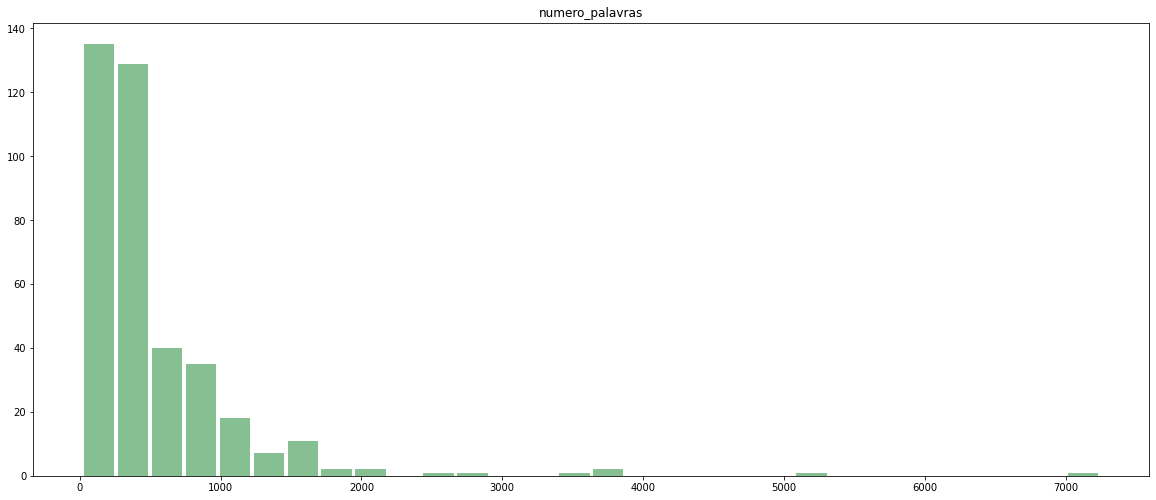

In [ ]:
ax = df.hist(column='numero_palavras', bins=30, grid=False, figsize=(20,30), layout=(3,1), sharex=True, color='#86bf91', zorder=2, rwidth=0.9)


*A quantidade de textos com tamanho (número palavras) próximo a 512 ou maior é grande. Importante lembrar que temos wordpieces então podemos ter textos com 320 a 400 palavras que passem de 512 tokens, já que o tokenizador poderá gerar vários tokens nas palavras que não conhece. 
Como é muito considerável a perda caso utilizassemos o truncamento de tokens caso os textos gerassem mais de 512 tokens então optamos por criar algoritmos que particionam os textos.*

**Quantidade de entidades por tipo que aparecem em cada texto**

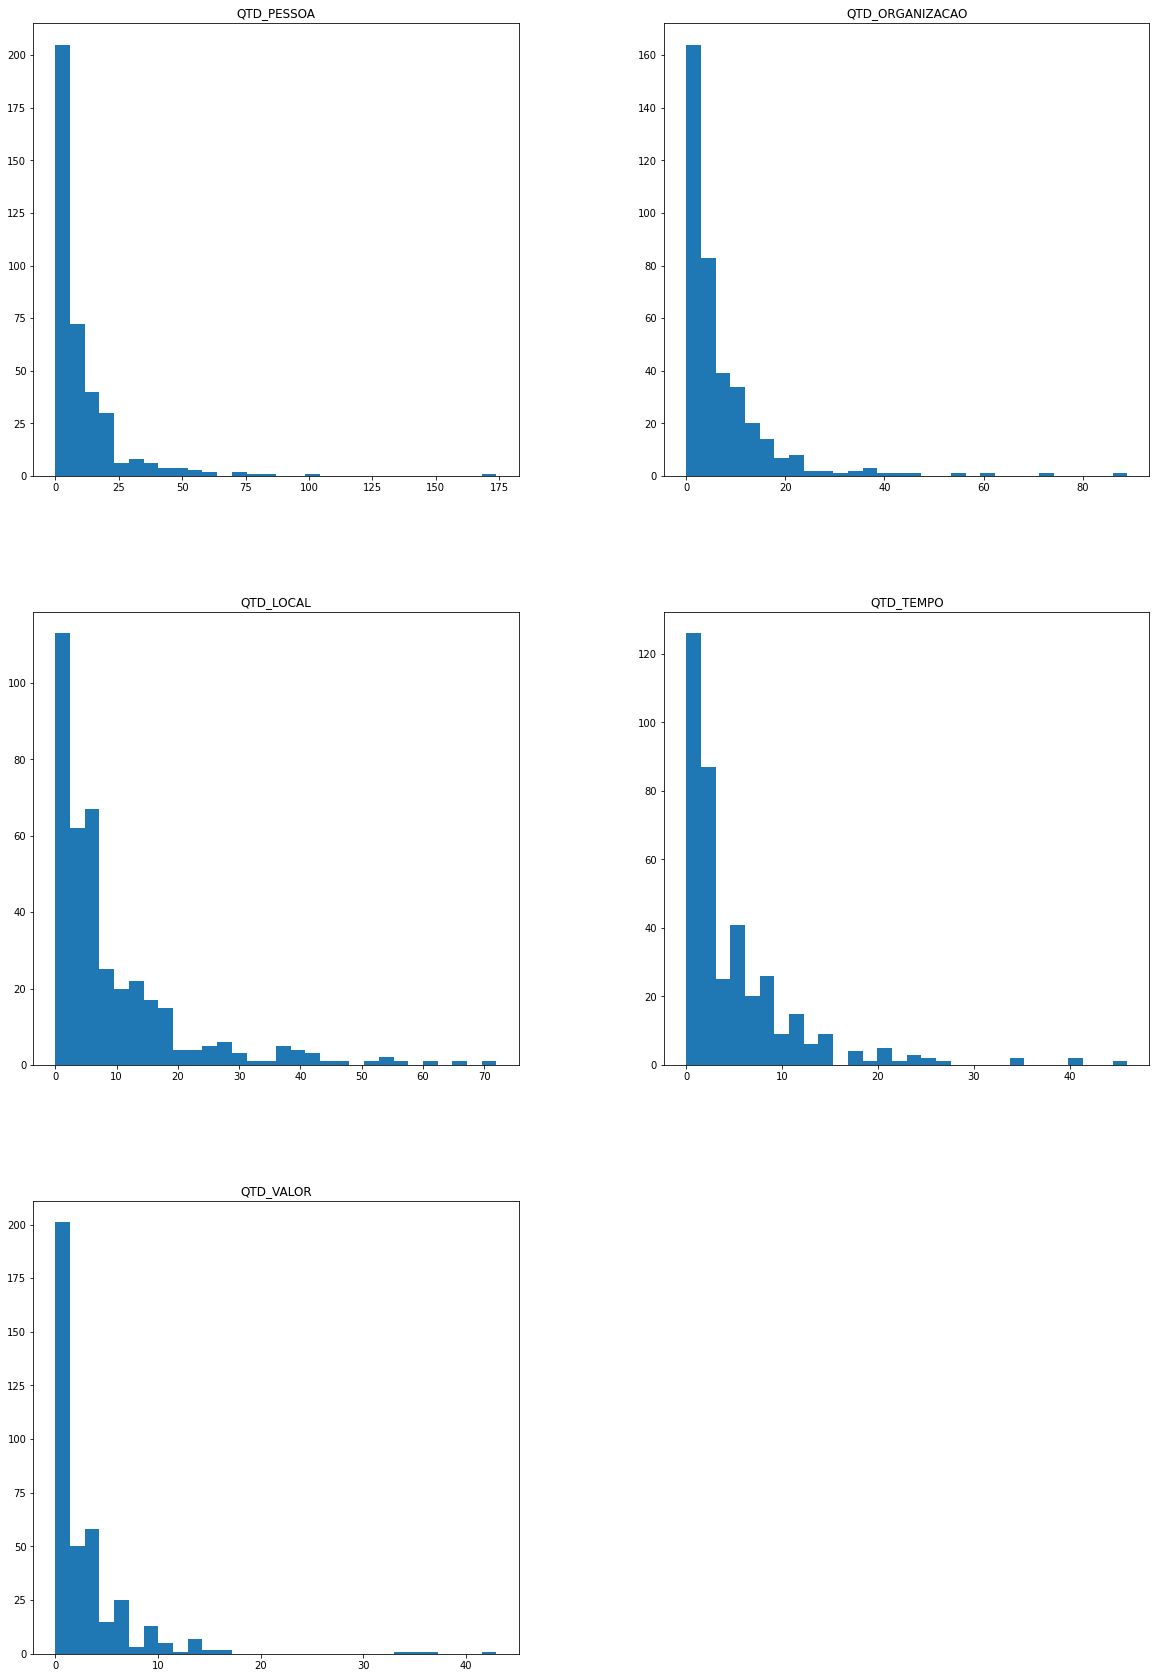

In [ ]:
ax = df.hist(column=['QTD_PESSOA','QTD_ORGANIZACAO','QTD_LOCAL', 'QTD_TEMPO', 'QTD_VALOR'], bins=30, grid=False, figsize=(20,30))

## 7 - Preparação dos Datasets

In [ ]:
def align_tokens(batch_encoding :BatchEncoding, 
                list_annotations: List[List[Anotacao]], 
                label_ner: LabelNER) -> TrainingBatchExample:

    """

    Alinhamento dos tokens e respectivos labels para tratar a disparidade gerada pelos Tokenizadores Bert que tratam palavras não encontradas com Worpieces.
    As anotações dos datasets foram criadas levando em conta palavras, mas os tokenizadores incluem partes de palavras (wordpieces), exemplo:
    Starbucks --> Star, ##bu, ##cks. A anotação faz referência a uma entrada B-Location, contudo três entradas deverão ser tratadas após a tokenização.

    Args:
        batch_encoding (BatchEncoding):
            Batch encoding previamente tokenizado (input_ids, attention_mask). 
            Contém lista de Encodings gerados pelo Tokenizador ao fazer a tokenização.
            O modelo é preparado para receber esse tipo de dado, por isso sua estrutura será preservada.
        
        list_annotations(List[List[Anotacao]])
            Lista onde cada entrada contém a lista de anotações de um documento 
        
        label_ner(LabelNER):
            Objeto da classe LabelNER que contém os labels e seus respectivos id's. Será utilizada para converter os labels de string para identificadores.

        Returns:
            TrainingBatchExamples:
                TrainingBatchExamples contendo o BatchEncoding passado e os labels alinhados

    """

    list_aligned_labels: List[List[int]] = []

    for ind_encoding in range(len(batch_encoding.encodings)):
        encoding: Encoding = batch_encoding[ind_encoding]
        annotations = list_annotations[ind_encoding]

        aligned_labels_str: List[str] = align_tokens_from_span_annotations(encoding, annotations)
        
        list_aligned_labels.append(label_ner.convert_label_list_to_id_list(aligned_labels_str))

    training_batch = TrainingBatchExample(batch_encoding, list_aligned_labels)
    
    return training_batch


In [ ]:
def align_tokens_from_span_annotations(encoding: Encoding, annotations: List[Anotacao]) -> List[str]:
    """

    Alinhamento das anotações de um documento com as wordpieces.
    
    Args:
        encoding (Encoding):
            Enconding da sentença previamente tokenizada (input_ids, attention_mask)            
        
        annotations(List[Anotacao])
            Lista de spans das entidades. Cada entrada do dicionário contém o label, inicio e fim de uma entidade que pode conter uma ou mais palavras.
            A função espera receber anotações com as seguintes entradas:
                - start - inicio do span
                - end - fim do span
                - label - label do span. Não é esperado que o label contenha os prefixos IOB ou BILOU, somente o nome do label.

        Returns:
            List[str]
                Anotações alinhadas com os tokens

    """

    
    begin_prefix: str='B'
    inside_prefix: str='I'

    tokens = encoding.tokens
    aligned_labels: List[str] = ["O"] * len(tokens)  # Make a list to store our labels the same length as our tokens
    for anno in annotations:
        annotation_token_ix_set = (set())  # A set that stores the token indices of the annotation
        for char_ix in range(anno.start_offset, anno.end_offset):
            token_ix = encoding.char_to_token(char_ix)
            if token_ix is not None:
                if not tokens[token_ix] in PUNCTUATION_LIST: # alguns datasets incluem caracteres de pontuação na entidade por falha nas anotações
                    annotation_token_ix_set.add(token_ix)

        if len(annotation_token_ix_set) == 1:
            # If there is only one token
            token_ix = annotation_token_ix_set.pop()
            aligned_labels[token_ix] = f"{begin_prefix}-{anno.label}"

        else:
            last_token_in_anno_ix = len(annotation_token_ix_set) - 1
            for num, token_ix in enumerate(sorted(annotation_token_ix_set)):                
                if num == 0:
                    prefix = begin_prefix                
                else:
                    prefix = inside_prefix
                aligned_labels[token_ix] = f"{prefix}-{anno.label}"
    return aligned_labels

In [ ]:
def prepara_docs_to_bert(doc_list: List[Document], tokenizer:BertTokenizerFast, limite_tokens:int=512) -> List[Document]:
    """
        Tokenização dos documentos e particionamento de um documento em vários, caso necessário, para evitar a perda de dados para treinamento/validação.

        Args:
            doc_list(List[Document]):
                lista de documentos para preparação
            tokenizer(BertTokenizerFast)
                Tokenizador utilizado, vai separar os tokens de acordo com o vocabulário disponível  
            limite_tokens(int)
                Quantidade máxima de tokens por documento

        Returns:
            Lista de documentos com tamanho menor ou igual ao limite de tokens informado. A quantidade de documentos retornados é sempre maior ou igual a quantidade
            informada pelo parametro doc_list

    """

    lista_doc_preparado = []
    for doc in doc_list:
        encoding:Encoding = tokenizer(doc.text)[0]
        if len(encoding.tokens) <= limite_tokens:
            lista_doc_preparado.append(doc)
            continue

        doc_particionado, doc_residual = particiona_doc(doc, encoding, limite_tokens)
        lista_doc_preparado.append(doc_particionado)
        while doc_residual is not None:
            encoding = tokenizer(doc_residual.text)[0]
            doc_particionado, doc_residual = particiona_doc(doc_residual, encoding, limite_tokens)
            lista_doc_preparado.append(doc_particionado)
    
    return lista_doc_preparado


In [ ]:
def particiona_doc(doc: Document, encoding: Encoding, limite_tokens) -> Tuple[Document,Document]:
    """ 
        Particiona o documento caso a quantidade de tokens seja maior que o limite, gerando um segundo documento com os tokens que sobraram.        
        A quebra do documento não acontece no limite dos tokens, mas no último separador de sentença disponível ('.', '!' ou '?' )

        Args:
            doc(Document):
                documento que será particionado (caso necessário)
            encoding(Encoding)
                Encoding do documento, contendo os id`s do vocabulário (não será utilizado), tokens e offsets (ambos importantes para a separação)  
            limite_tokens(int)
                Quantidade máxima de tokens por documento            

        Returns: (Document, Document)
            Documento particionado com as anotações preservadas
            Documento residual com as anotações deslocadas

    """

    # Verifica se é necessário particionar
    if len(encoding.tokens) <= limite_tokens:
        return doc, None

    # reservar a posição do [SEP] na tokenização    
    pos_quebra = limite_tokens -1;
    achou_pos_quebra = False
    while not achou_pos_quebra and pos_quebra > 0:
        if encoding.tokens[pos_quebra] in SEPARADOR_SENTENCA:
            achou_pos_quebra = True
        else:
            pos_quebra -= 1


    # Se não encontrar o separadar até o inicio então teremos que separar sentenças no meio
    if not achou_pos_quebra:
        pos_quebra = limite_tokens -1

    # final do token de quebra
    offset_quebra = encoding.offsets[pos_quebra][1]
    offset_inicio_doc_residual = encoding.offsets[pos_quebra+1][0]
    doc_particionado = Document()
    doc_residual = Document()

    doc_particionado.text = doc.text[0:offset_quebra]
    doc_residual.text = doc.text[offset_inicio_doc_residual:]

    for anotacao in doc.lista_anotacao:
        nova_anotacao = Anotacao()
        nova_anotacao.copy_from(anotacao)
        if nova_anotacao.start_offset < offset_quebra:
            doc_particionado.adiciona_anotacao(nova_anotacao)
        else:
            nova_anotacao.start_offset -= offset_inicio_doc_residual
            nova_anotacao.end_offset -= offset_inicio_doc_residual
            doc_residual.adiciona_anotacao(nova_anotacao)


    doc_particionado.conta_palavras()
    doc_residual.conta_palavras()

    return doc_particionado,doc_residual


In [ ]:
# separação dos datasets de treino, validação e teste
train_doc_list, test_doc_list = train_test_split(lista_doc_harem, test_size=0.1, random_state=42)
train_doc_list, val_doc_list = train_test_split(train_doc_list, test_size=0.1, random_state=42)

In [ ]:
print(len(train_doc_list))
print(len(val_doc_list))
print(len(test_doc_list))


312
35
39


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_BASE)

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# Exemplo comentado para o artigo
#print(lista_doc_harem[0])
#lista = separa_doc_caso_necessario([lista_doc_harem[0]],tokenizer=tokenizer,limite_tokens=100)
#print(lista)
#print(lista[3].text)
#print(lista[3].lista_anotacao)
#lista[3].text[448:466]

In [ ]:
train_doc_list = prepara_docs_to_bert(doc_list = train_doc_list, tokenizer=tokenizer, limite_tokens=512)
val_doc_list = prepara_docs_to_bert(doc_list = val_doc_list, tokenizer=tokenizer, limite_tokens=512)

In [ ]:
label_ner: LabelNER = LabelNER() 
label_ner.load_from_simple_list(LABEL_LIST)

In [ ]:
train_text_list = []
train_annotation_list = []
for doc in train_doc_list:
    train_text_list.append(doc.text)
    train_annotation_list.append(doc.lista_anotacao)

val_text_list = []
val_annotation_list = []
for doc in val_doc_list:
    val_text_list.append(doc.text)
    val_annotation_list.append(doc.lista_anotacao)


In [ ]:
train_batch_encoding = tokenizer(train_text_list, max_length=512, padding="max_length", truncation=True)
val_batch_encoding = tokenizer(val_text_list, max_length=512, padding="max_length", truncation=True)

In [ ]:
train_batch_example:TrainingBatchExample = align_tokens(train_batch_encoding, 
                                                        train_annotation_list,
                                                        label_ner=label_ner)

val_batch_example:TrainingBatchExample = align_tokens(val_batch_encoding, 
                                                    val_annotation_list,
                                                    label_ner=label_ner)

In [ ]:
indice = 100
print(train_text_list[indice])
print(train_batch_example.batch_encoding.encodings[indice].tokens)
print(train_batch_example.batch_encoding.encodings[indice].offsets)
print(label_ner.convert_id_list_to_label_list(train_batch_example.labels[indice]))

Di Bello Informática... seu Polo de Informática em MADUREIRA- A mais antiga loja de Informática em Madureira, são vinte anos de credibilidade...Hardware, software, suprimentos e manutenção. http://www.webspace.com.br/dibello. Diacon Informática- A Diacon presta serviços de consultoria, treinamento e desenvolvimento de sistemas. http://www.diacon.com.br.
['[CLS]', 'Di', 'Bell', '##o', 'Inf', '##orm', '##ática', '.', '.', '.', 'seu', 'Polo', 'de', 'Inf', '##orm', '##ática', 'em', 'MA', '##D', '##UR', '##EI', '##RA', '-', 'A', 'mais', 'antiga', 'loja', 'de', 'Inf', '##orm', '##ática', 'em', 'Mad', '##ure', '##ira', ',', 'são', 'vinte', 'anos', 'de', 'cred', '##ibilidade', '.', '.', '.', 'Hard', '##ware', ',', 'software', ',', 'suprimentos', 'e', 'manutenção', '.', 'http', ':', '/', '/', 'w', '##ww', '.', 'web', '##s', '##pace', '.', 'com', '.', 'b', '##r', '/', 'di', '##bell', '##o', '.', 'Dia', '##con', 'Inf', '##orm', '##ática', '-', 'A', 'Dia', '##con', 'pres', '##ta', 'serviços', 'de'

## 8 - Treinamento

In [ ]:
model = BertForTokenClassification.from_pretrained(MODEL_BASE, num_labels=len(label_ner))
model.to('cuda')

In [ ]:
train_dataset = NERDataset(train_batch_example)
val_dataset = NERDataset(val_batch_example)

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=100,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=20,
    evaluation_strategy='steps',
    save_strategy='steps',
    load_best_model_at_end=True

)

In [ ]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

In [ ]:
trainer.train()

trainer.save_model(MODEL_TRAINED_PATH)
label_ner.save(LABEL_OUTPUT_PATH)

destroy_model(model)
print(get_gpu_memory_status())
destroy_tokenizer(tokenizer)
print(get_gpu_memory_status())

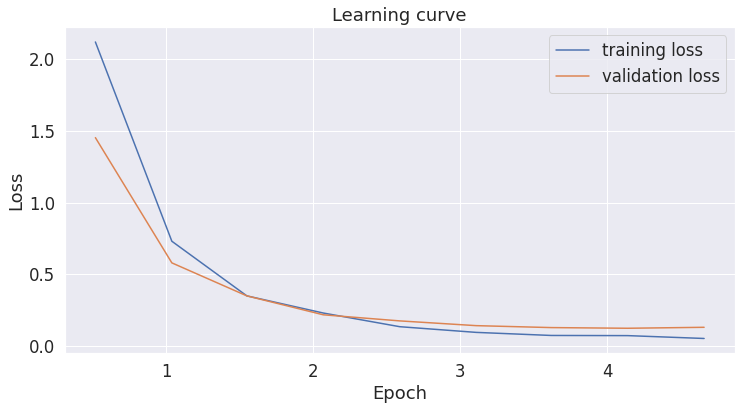

In [ ]:
  #grafico sobre train e evaluation loss
df = pd.read_csv(MODEL_TRAINED_LOG,sep='\t')
df['Epoch'] = round((df.Step * training_args.per_device_train_batch_size) / len(train_dataset), 2)
df.tail(10)

train_loss = df[['Epoch', 'Training Loss']].to_numpy()
validation_loss = df[['Epoch', 'Validation Loss']].to_numpy()

plot_grafico_trainer_loss(train_loss, validation_loss)

In [ ]:
destroy_model(model)
destroy_tokenizer(tokenizer)

## 9 - Execução do Modelo - Teste

In [ ]:
def prepara_NER_prediction_for_metrics(tokenizer: Union[BertTokenizerFast], 
                                       batch_encoding: BatchEncoding, 
                                       test_labels: numpy.ndarray, 
                                       pred_labels: numpy.ndarray):
    """
        Ajusta da predição realizada pelo NER para avaliação das métricas.
        Os seguintes tokens de controle devem ser ignorados: [PAD], [SEP], [CLS]. Ignorar representa atribuir o valor correto à predição,
        não importando para a medição comparar o que foi previsto para os tokens de controle.

        Args:
            tokenizer (BertTokenizerFast,DistilBertTokenizerFast):
                Tokenizer utiilzado no modelo, foi o responsável por tokenizar o batch_encoding.

            batch_encoding (BatchEncoding):
                Batch enconding das sentenças tokenizadas utilizando o tokenizer passado por parametro. Será usado caso os wordpieces sejam ignorados.
            
            test_labels (:obj:`numpy.ndarray(int)`):
                Array com os valores corretos dos labels.
            
            pred_labels (:obj:`numpy.ndarray(int)`):
                Array com os valores inferido pelo modelo.

        Returns:
            :obj:`numpy.ndarray(int)`:
                Vetor de predição preparado para aplicação de métricas.
    """
    control_encodings:BatchEncoding = tokenizer(CONTROL_TOKENS)
    ignored_tokens = set([token_id for control_sent in control_encodings.input_ids for token_id in control_sent])
    
    for ind_encoding in range(len(batch_encoding.encodings)):
        encoding:Encoding = batch_encoding[ind_encoding]
        
        for ind_token,input_id in enumerate(encoding.ids):
            if input_id in ignored_tokens:
                if pred_labels[ind_encoding][ind_token] != test_labels[ind_encoding][ind_token]:
                    #print(input_id,' [', ind_encoding, ',', ind_token, '] -', pred_labels[ind_encoding][ind_token], '--> ', test_labels[ind_encoding][ind_token] )
                    pred_labels[ind_encoding][ind_token] = test_labels[ind_encoding][ind_token]

    return pred_labels

In [ ]:
model = BertForTokenClassification.from_pretrained(MODEL_TRAINED_PATH)
tokenizer = AutoTokenizer.from_pretrained(MODEL_BASE)
model.to('cuda')

In [ ]:
get_gpu_memory_status()

'Total: 16280.88 | Reserved: 2220.00 | Allocated: 2074.88'

In [ ]:
label_ner = LabelNER()
label_ner.load_from_file(LABEL_OUTPUT_PATH)

In [ ]:
test_doc_list = prepara_docs_to_bert(doc_list=test_doc_list, tokenizer=tokenizer, limite_tokens=512)

In [ ]:
test_text_list = []
test_annotation_list = []
for doc in test_doc_list:
    test_text_list.append(doc.text)
    test_annotation_list.append(doc.lista_anotacao)

In [ ]:
test_batch_encoding = tokenizer(test_text_list, max_length=512, padding="max_length", truncation=True)

In [ ]:
test_batch_example:TrainingBatchExample = align_tokens(test_batch_encoding, 
                                                        test_annotation_list,
                                                        label_ner=label_ner)

In [ ]:
test_dataset = NERDataset(test_batch_example)

In [ ]:
loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
loop = tqdm(loader, leave=True)
final_output_loss = []
final_output_logits = []

for it, batch in enumerate(loop):

    input_ids = batch['input_ids'].to('cuda')
    attention_mask = batch['attention_mask'].to('cuda')
    labels = batch['labels'].to('cuda')

    outputs = model(input_ids=input_ids, 
                    attention_mask=attention_mask, 
                    labels=labels)
    
    final_output_loss.append(outputs.loss.detach().to('cpu').numpy())
    final_output_logits.append(outputs.logits.detach().to('cpu').numpy())

    input_ids.detach()
    attention_mask.detach()
    labels.detach
    labels = None
    input_ids = None
    attention_mask = None
    outputs.logits = None
    outputs.loss = None
    outputs = None
    gc.collect()
    torch.cuda.empty_cache()


100%|██████████| 6/6 [00:04<00:00,  1.41it/s]


In [ ]:
get_gpu_memory_status()

'Total: 16280.88 | Reserved: 2220.00 | Allocated: 2075.00'

In [ ]:
destroy_model(model)
get_gpu_memory_status()

'Total: 16280.88 | Reserved: 2220.00 | Allocated: 2075.00'

In [ ]:
test_preds = np.vstack(final_output_logits)
test_preds = np.argmax(test_preds, axis=-1)
test_preds = prepara_NER_prediction_for_metrics(tokenizer=tokenizer, 
                                                batch_encoding=test_dataset.encodings,
                                                test_labels=test_dataset.labels, 
                                                pred_labels=test_preds)

In [ ]:
y_true = np.array(test_dataset.labels).ravel()
y_pred = test_preds.ravel()


score = f1_score(y_true=y_true, y_pred=y_pred, average='weighted')
print('Weighted - ', score)
score = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
print('Micro - ', score)
score = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
print('Macro - ', score)

Weighted -  0.9735422259451593
Micro -  0.9732638888888889
Macro -  0.8095561812886692


In [ ]:
destroy_tokenizer(tokenizer)
get_gpu_memory_status()

## 10 - Testes com textos fora do Harem

In [ ]:
class Span_Entity:

    def __init__(self):
        self.label: str = ''
        self.start: int = -1
        self.end: int = -1
    
    def to_tuple(self) -> Tuple[int,int,str]:
        return (self.start, self.end, self.label)


def mount_ner_prediction_spans_to_visualization(batch_encoding: BatchEncoding, label_list: List[List[str]]) -> List[Tuple[int,int,str]]:
    """
        Dado um conjunto de encodings gerados pelo tokenizador Bert e os respectivos labels, a função criará os spans para visualização do texto e entidades, agrupando as entidades.
        A função pode ser utilizad por labels inferidos por um modelo ou obtidos por um dataset

        Args:
            batch_encoding(BatchEncoding):
                Conjunto de encodings gerados após a tokenização do Bert (exige que seja um tokenizador Fast por causa dos offset)

            label_list(List[List[str]]):
                Lista com uma lista de Labels no formato IOB ('O', 'B-<entidade>', 'I-<entidade>')

        Returns(List[List[Tuple[int,int,str]]]):
            Retorna lista com a lista dos spans das entidades para visualização do NER, retirando os prefixos B-/I- da representação IOB

    """
    batch_span_list: List[List[Tuple[int,int,str]]] = []

    for idx_encoding in  range(len(batch_encoding.encodings)):
        encoding:Encoding = batch_encoding[idx_encoding]
        span_list = []
        batch_span_list.append(span_list)

        span_atual: Span_Entity = None
        for idx_label,label in enumerate(label_list[idx_encoding]):
            token_atual = encoding.tokens[idx_label]

            if label == 'O' or token_atual in CONTROL_TOKENS:
                if span_atual is not None:
                    span_list.append(span_atual.to_tuple())
                    span_atual = None
            elif label.startswith('B-'):
                if span_atual is not None:
                    span_list.append(span_atual.to_tuple())
                span_atual = Span_Entity()
                span_atual.label = label[2:]
                span_atual.start = encoding.offsets[idx_label][0]
                span_atual.end = encoding.offsets[idx_label][1]

            elif label.startswith('I-'):
                if span_atual is None:
                    if token_atual not in CONTROL_TOKENS:
                        print(f'Info - Encontrado uma entidade com prefixo I- sem uma entidade anterior com B-. Encoding({idx_encoding},{encoding.tokens[idx_label]}) Label({idx_label},{label})')
                else:
                    span_atual.end = encoding.offsets[idx_label][1]
            else:
                raise ValueError(f'Prefixo de Label não esperado {label}')

            # tratar o ultimo token sendo I- ou B-
            if (idx_label == len(label_list[idx_encoding]) -1):
                if span_atual is not None:
                    span_list.append(span_atual.to_tuple())

    return batch_span_list


In [ ]:
model = BertForTokenClassification.from_pretrained(MODEL_TRAINED_PATH)
tokenizer = AutoTokenizer.from_pretrained(MODEL_BASE)
model.to('cuda')

In [ ]:
label_ner = LabelNER()
label_ner.load_from_file(LABEL_OUTPUT_PATH)

In [ ]:
get_gpu_memory_status()

'Total: 16280.88 | Reserved: 450.00 | Allocated: 414.51'

In [ ]:
texto1 = 'Pateta (em inglês, Goofy) é um personagem de animação dos Estúdios Walt Disney criado em 1932. Ele é um cão antropomórfico da raça Bloodhound de aparência magra, esguia, alta, e desengonçada. É conhecido pelo público por seu jeito atrapalhado, engraçado e bondoso e por seu chapéu singular. Seu nome seria um apelido, pois nos curtas dos anos 50 e 60 era chamado "George Geef" ou "G. G. Goof". Fontes atuais como o desenho A Turma do Pateta dão seu nome completo como Pateta Pateta.' 
texto2 = 'O secretário-executivo do ministério, Rodrigo Cruz, afirmou que o debate sobre a campanha 2022 com especialistas envolveu diversas dúvidas e perguntas, tais como qual será o público-alvo da vacinação, quais imunizantes usar e quando aplicar as doses. "Hoje o mundo não tem essas respostas", disse Cruz. "Diversos cenários foram elaborados e levamos em consideração de 2 doses caso tenha ampliação de publico alvo, como menores de 12 anos. Para o público de 18 a 60 anos, vai ter 1 dose. E mais de 60 e imunossuprimidos, vão ter 2 doses. Esse é o cenário escolhido para 2022 e por faixa etária decrescente. Nesse primeiro momento", reforçou Cruz.' 
texto3= 'Nesta quinta-feira (7), o Masters 1000 de Indian Wells volta a ser disputado oficialmente. Conhecido como o "quinto Grand Slam" por conta da estrutura e do tamanho da chave com relação às outras competições desse nível, o torneio foi o primeiro a ser cancelado no ano passado por conta da pandemia do novo Coronavírus e chegou a ser adiado em 2021, mas enfim vai acontecer. De quebra, retorna com um atrativo garantido: um campeão inédito será coroado na Califórnia.'
texto4= 'O sistema operacional Unix foi concebido e implementado em 1969 pela AT&T Bell Laboratories nos Estados Unidos por Ken Thompson, Dennis Ritchie, Douglas McIlroy, e Joe Ossanna. Lançado pela primeira vez em 1971, o Unix foi escrito inteiramente em linguagem assembly uma prática comum para a época. Mais tarde, em 1973, o sistema foi reescrito na linguagem de programação C por Dennis Ritchie.[10] A disponibilidade de uma implementação do Unix feita em linguagem de alto nível fez a sua portabilidade para diferentes plataformas de computador se tornarem mais fácil. Na época, a maioria dos programas era escrita em cartões perfurados que tinham de ser inseridos em lotes em computadores mainframe.'
texto5 = 'O Brasil registrou neste domingo (10) 167 mortes por Covid-19 nas últimas 24 horas, com o total de óbitos chegando a 601.047 desde o início da pandemia. Com isso, a média móvel de mortes nos últimos 7 dias ficou em 437 --a menor registrada desde 13 de novembro de 2020 (quando estava em 403). Em comparação à média de 14 dias atrás, a variação foi de -17% e aponta queda.'
texto6 = 'O relatório final da CPI da Covid no Senado, a ser apresentado e votado ainda neste mês, deve listar pelo menos 11 crimes atribuídos ao presidente Jair Bolsonaro, afirmou à GloboNews neste domingo (10) o relator da comissão, senador Renan Calheiros (MDB-AL). A lista, segundo Renan, inclui crimes de responsabilidade, crimes contra a saúde pública e mesmo crimes contra a humanidade, além de condutas previstas no Código Penal.'
real_batch_text=[texto1,texto2,texto3,texto4,texto5,texto6]

In [ ]:
real_test_batch_encoding = tokenizer(real_batch_text, max_length=512, padding="max_length", truncation=True)
real_test_dataset = NERDataset(real_test_batch_encoding)
real_test_loader = torch.utils.data.DataLoader(real_test_dataset, batch_size=4, shuffle=False)

In [ ]:
print(len(real_test_loader))

2


In [ ]:
final_output_real_test_logits = []
for idx,batch in enumerate(real_test_loader):
    
    input_ids = batch['input_ids'].to('cuda')
    attention_mask = batch['attention_mask'].to('cuda')

    outputs = model(input_ids=input_ids, 
                    attention_mask=attention_mask)
    
    final_output_real_test_logits.append(outputs.logits.detach().to('cpu').numpy())

    input_ids.detach()
    attention_mask.detach()
    input_ids = attention_mask = outputs.logits = outputs.loss = None
    outputs = None
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
real_test_preds = np.vstack(final_output_real_test_logits)
real_test_preds = np.argmax(real_test_preds, axis=-1)
real_test_preds = [label_ner.convert_id_list_to_label_list(p) for p in real_test_preds]

In [ ]:
print(len(real_test_preds))
print(real_test_batch_encoding.encodings[0].tokens)
print(real_test_batch_encoding.encodings[0].offsets)
print(real_test_preds[0])
print(real_test_batch_encoding.encodings[0].tokens[80:86])
print(real_test_preds[0][80:86])

6
['[CLS]', 'Pat', '##eta', '(', 'em', 'inglês', ',', 'Go', '##of', '##y', ')', 'é', 'um', 'personagem', 'de', 'animação', 'dos', 'Est', '##údio', '##s', 'Walt', 'Disney', 'criado', 'em', '1932', '.', 'Ele', 'é', 'um', 'cão', 'antrop', '##om', '##ór', '##fico', 'da', 'raça', 'Blood', '##hou', '##nd', 'de', 'aparência', 'mag', '##ra', ',', 'es', '##guia', ',', 'alta', ',', 'e', 'desen', '##gon', '##çada', '.', 'É', 'conhecido', 'pelo', 'público', 'por', 'seu', 'jeito', 'atrapal', '##hado', ',', 'engra', '##çado', 'e', 'bon', '##doso', 'e', 'por', 'seu', 'chapéu', 'singular', '.', 'Seu', 'nome', 'seria', 'um', 'apelido', ',', 'pois', 'nos', 'curtas', 'dos', 'anos', '50', 'e', '60', 'era', 'chamado', '"', 'George', 'Ge', '##e', '##f', '"', 'ou', '"', 'G', '.', 'G', '.', 'Go', '##of', '"', '.', 'Fontes', 'atuais', 'como', 'o', 'desenho', 'A', 'Tur', '##ma', 'do', 'Pat', '##eta', 'dão', 'seu', 'nome', 'completo', 'como', 'Pat', '##eta', 'Pat', '##eta', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]

In [ ]:
batch_pred_span = mount_ner_prediction_spans_to_visualization(batch_encoding=real_test_batch_encoding,label_list=real_test_preds)

Info - Encontrado uma entidade com prefixo I- sem uma entidade anterior com B-. Encoding(0,anos) Label(85,I-TEMPO)
Info - Encontrado uma entidade com prefixo I- sem uma entidade anterior com B-. Encoding(0,50) Label(86,I-TEMPO)
Info - Encontrado uma entidade com prefixo I- sem uma entidade anterior com B-. Encoding(0,e) Label(87,I-TEMPO)
Info - Encontrado uma entidade com prefixo I- sem uma entidade anterior com B-. Encoding(0,60) Label(88,I-TEMPO)
Info - Encontrado uma entidade com prefixo I- sem uma entidade anterior com B-. Encoding(4,04) Label(32,I-VALOR)
Info - Encontrado uma entidade com prefixo I- sem uma entidade anterior com B-. Encoding(4,##7) Label(33,I-VALOR)
Info - Encontrado uma entidade com prefixo I- sem uma entidade anterior com B-. Encoding(5,##vid) Label(9,I-ORGANIZACAO)
Info - Encontrado uma entidade com prefixo I- sem uma entidade anterior com B-. Encoding(5,mês) Label(20,I-TEMPO)
Info - Encontrado uma entidade com prefixo I- sem uma entidade anterior com B-. Encod

In [ ]:
for idx,text in enumerate(real_batch_text):
    show_line_markup(text, batch_pred_span[idx], palette=palette(GREEN))
    #show_box_markup(text, batch_pred_span[idx])
    print(' ')
    print('-----------------------------------------------------------')
    print(' ')

 
-----------------------------------------------------------
 


 
-----------------------------------------------------------
 


 
-----------------------------------------------------------
 


 
-----------------------------------------------------------
 


 
-----------------------------------------------------------
 


 
-----------------------------------------------------------
 
